See [github repo](https://github.com/TimotheeMathieu/IllustrationRobustML) for ipynb files 

In this notebook, we illustrate the robust properties of [RobustWeighdedClassifier](https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.robust.RobustWeightedClassifier.html#sklearn_extra.robust.RobustWeightedClassifier) on a toy example made of three Gaussian blobs, two of which are informative data. The third blob contain outliers that we want to ignore in our application. 

We compare our agorithm with [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) algorithm for different loss functions. Notice that the "robust" loss functions named `modified_huber_loss` for SGDClassifier makes an estimator that is in fact robust to outliers in $y$ (and this is the same for `log` and `hinge` loss by the way) but not to outliers in the feature space $X$.

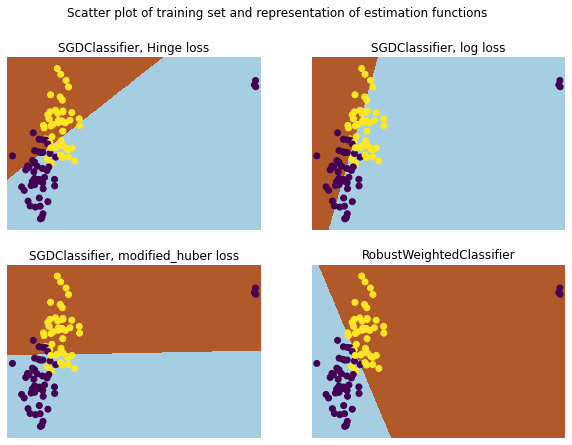

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn_extra.robust import RobustWeightedClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

rng = np.random.RandomState(42)

# Sample two Gaussian blobs
X, y = make_blobs(
    n_samples=100, centers=np.array([[-1, -1], [1, 1]]), random_state=rng
)

# Change the first 3 entries to outliers
for f in range(3):
    X[f] = [20, 3] + rng.normal(size=2) * 0.1
    y[f] = 0

# Shuffle the data so that we don't know where the outlier is.
X, y = shuffle(X, y, random_state=rng)

estimators = [
    (
        "SGDClassifier, Hinge loss",
        SGDClassifier(loss="hinge", random_state=rng),
    ),
    ("SGDClassifier, log loss", SGDClassifier(loss="log", random_state=rng)),
    (
        "SGDClassifier, modified_huber loss",
        SGDClassifier(loss="modified_huber", random_state=rng),
    ),
    (
        "RobustWeightedClassifier",
        RobustWeightedClassifier(
            max_iter=100,
            weighting="mom",
            k=8,
            random_state=rng,
        ),
        # The parameter k is set larger the number of outliers
        # because here we know it. max_iter is set to 100. One may want
        # to play with the number of iteration or the optimization scheme of
        # the base_estimator to get good results.
    ),
]


# Helping function to represent estimators
def plot_classif(clf, X, y, ax):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')
    ax.scatter(X[:, 0], X[:, 1], c=y)


fig, axes = plt.subplots(2, 2, figsize=(10,7))

for i, (name, estimator) in enumerate(estimators):
    ax = axes.flat[i]
    estimator.fit(X, y)
    plot_classif(estimator, X, y, ax)
    ax.set_title(name)
    ax.axis("off")

fig.suptitle(
    "Scatter plot of training set and representation of"
    " estimation functions"
)
plt.show()
